# House Prices Prediction Using ML
- **Competition Title**: House Prices - Advanced Regression Techniques
- **Competition Host**: Kaggle
- **Competition Website**: [House Price Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
- **Competition Start**: 8/30/2016
- **Competition End**: No end date
- **Author**: Dare Afolabi
- **Kaggle Accounts**: [dafolabi](https://www.kaggle.com/dafolabi)
- **Submission Date**: 24 Sept 2025
- **Submission Count**: 1

## Load Libraries
Import standard libraries for data handling, visualization, preprocessing, model training, and evaluation.

In [14]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')  
sns.set_palette(['#008080'])   
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn import show_versions

## Read Training Dataset
Load the Ames Housing training data, inspect schema and memory usage.

In [3]:
housing_data = pd.read_csv('train.csv')

In [4]:
housing_data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Train-Test Split
Avoid leakages by spliting dataset into training and validation sets upstream of processing.

In [5]:
train_data, test_data = train_test_split(
    housing_data, test_size=0.2, random_state=42
)

In [6]:
# Drop ID column
train_data = train_data.drop('Id', axis=1)

## Missing Values Summary
Define helper functions to summarize and handle missing values by type (numeric vs categorical) and domain relevance (input median vs 0).

In [7]:
def missing_summary(df):
    '''
    Summarize missing values. Returns an array with column name, dtype, count of missing,
    number of unique values, and summary of values.
    '''
    summary = []
    
    for col in df.columns:
        n_missing = df[col].isna().sum()
        if n_missing == 0:
            continue 
        
        dtype = df[col].dtype
        
        if dtype == 'object': 
            col_type = 'categorical'
            n_unique = df[col].nunique(dropna = True)
            unique_vals = df[col].unique()
            summary.append({
                'Column': col,
                'Type': col_type,
                'NA_count': n_missing,
                'Unique_count': n_unique,
                'Details': unique_vals
            })
            
        elif np.issubdtype(dtype, np.number): 
            col_type = 'numeric'
            n_unique = df[col].nunique(dropna = True)
            col_min = df[col].min()
            col_max = df[col].max()
            col_median = df[col].median()
            summary.append({
                'Column': col,
                'Type': col_type,
                'NA_count': n_missing,
                'Unique_count': n_unique,
                'Details': f'Min= {col_min}, Max={col_max}, Median={col_median}'
            })

    return summary

# View as DataFrame
pd.DataFrame(missing_summary(train_data))

,Column,Type,NA_count,Unique_count,Details
0,LotFrontage,numeric,217,107,"Min= 21.0, Max=313.0, Median=70.0"
1,Alley,categorical,1094,2,"[nan, Pave, Grvl]"
2,MasVnrType,categorical,683,3,"[nan, BrkFace, Stone, BrkCmn]"
3,MasVnrArea,numeric,6,286,"Min= 0.0, Max=1378.0, Median=0.0"
4,BsmtQual,categorical,28,4,"[TA, Gd, Fa, nan, Ex]"
5,BsmtCond,categorical,28,4,"[TA, Fa, nan, Gd, Po]"
6,BsmtExposure,categorical,28,4,"[No, Av, Gd, Mn, nan]"
7,BsmtFinType1,categorical,28,6,"[Rec, Unf, ALQ, LwQ, BLQ, GLQ, nan]"
8,BsmtFinType2,categorical,28,6,"[Unf, LwQ, Rec, BLQ, nan, GLQ, ALQ]"
9,Electrical,categorical,1,4,"[SBrkr, FuseA, FuseF, FuseP, nan]"


In [8]:
# Store dictionaries for test use (avoids leakage while ensuring alignment)
neighborhood_lot_median = train_data.groupby('Neighborhood')['LotFrontage'].median().to_dict()
neighborhood_price_median = train_data.groupby('Neighborhood')['SalePrice'].median().to_dict()

# Helper function
def handle_missing(df):
    '''
    Imputs missing values as applicable.
    Returns dataframe with imputed values.
    '''
    df = df.copy()
    numeric_zero_if_na = ['MasVnrArea', 'GarageYrBlt']
    for col in numeric_zero_if_na:
        df[col] = df[col].fillna(0)
        
    df['LotFrontage'] = df['Neighborhood'].map(neighborhood_lot_median)
    
    summary_df = pd.DataFrame(missing_summary(df))
    categorical_cols = summary_df[summary_df['Type'] == 'categorical']['Column']
    
    for col in categorical_cols:
        df[col] = df[col].fillna('No_' + col)

    return df

train_data = handle_missing(train_data)

In [9]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.849315,69.187928,10689.642123,6.121575,5.584760,1970.965753,1984.897260,103.238870,446.023973,45.152397,...,95.946918,49.578767,21.839041,3.812500,15.407534,2.955479,51.267123,6.356164,2007.818493,181441.541952
std,42.531862,12.459979,10759.366198,1.367619,1.116062,30.675495,20.733955,172.746354,459.070977,158.217499,...,129.685939,69.433580,62.083227,31.519664,55.881148,41.648504,553.039684,2.670707,1.322639,77263.583862
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,65.000000,7587.250000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,50.000000,70.000000,9600.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,384.500000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165000.000000
75%,70.000000,74.500000,11700.000000,7.000000,6.000000,2001.000000,2004.000000,166.000000,721.000000,0.000000,...,168.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214925.000000
max,190.000000,91.500000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,1127.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,745000.000000


## Target Transformation
Apply log transformation to `SalePrice` to stabilize variance.

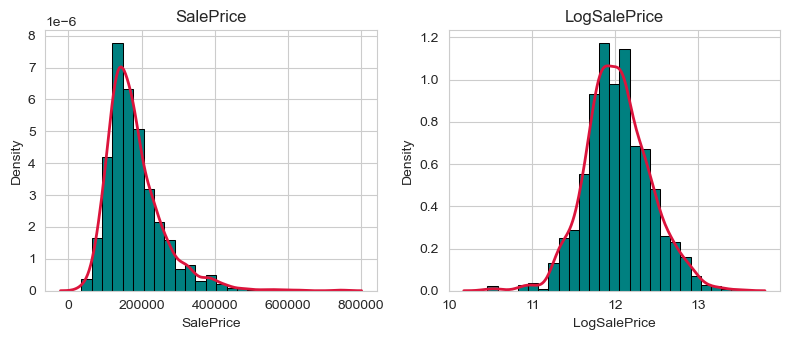

In [10]:
def target_transform(df):
    df = df.copy()
    df['SalePrice'] = df['SalePrice'].astype('float')
    df['LogSalePrice'] = np.log1p(df['SalePrice'])

    return df

train_data = target_transform(train_data)

fig, axes = plt.subplots(1, 2, figsize = (8, 3.5))

# SalePrice histogram and KDE
sns.histplot(
    train_data['SalePrice'],
    bins = 25,
    edgecolor = 'black',
    alpha = 1,
    stat = 'density',
    kde = False,
    ax = axes[0]
)
sns.kdeplot(
    train_data['SalePrice'],
    ax = axes[0],
    color = '#DC143C20',
    linewidth = 2
)
axes[0].set_title('SalePrice')

# LogSalePrice histogram and KDE
sns.histplot(
    train_data['LogSalePrice'],
    bins = 25,
    edgecolor = 'black',
    alpha = 1,
    stat = 'density',
    kde = False,
    ax = axes[1]
)
sns.kdeplot(
    train_data['LogSalePrice'],
    ax = axes[1],
    color = '#DC143C20',
    linewidth = 2
)
axes[1].set_title('LogSalePrice')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis
- Visualize distributions of `SalePrice` (see above) and `LogSalePrice` (see above), numeric, and categorical feature distributions.
- Recommend log transformation of skewed data.

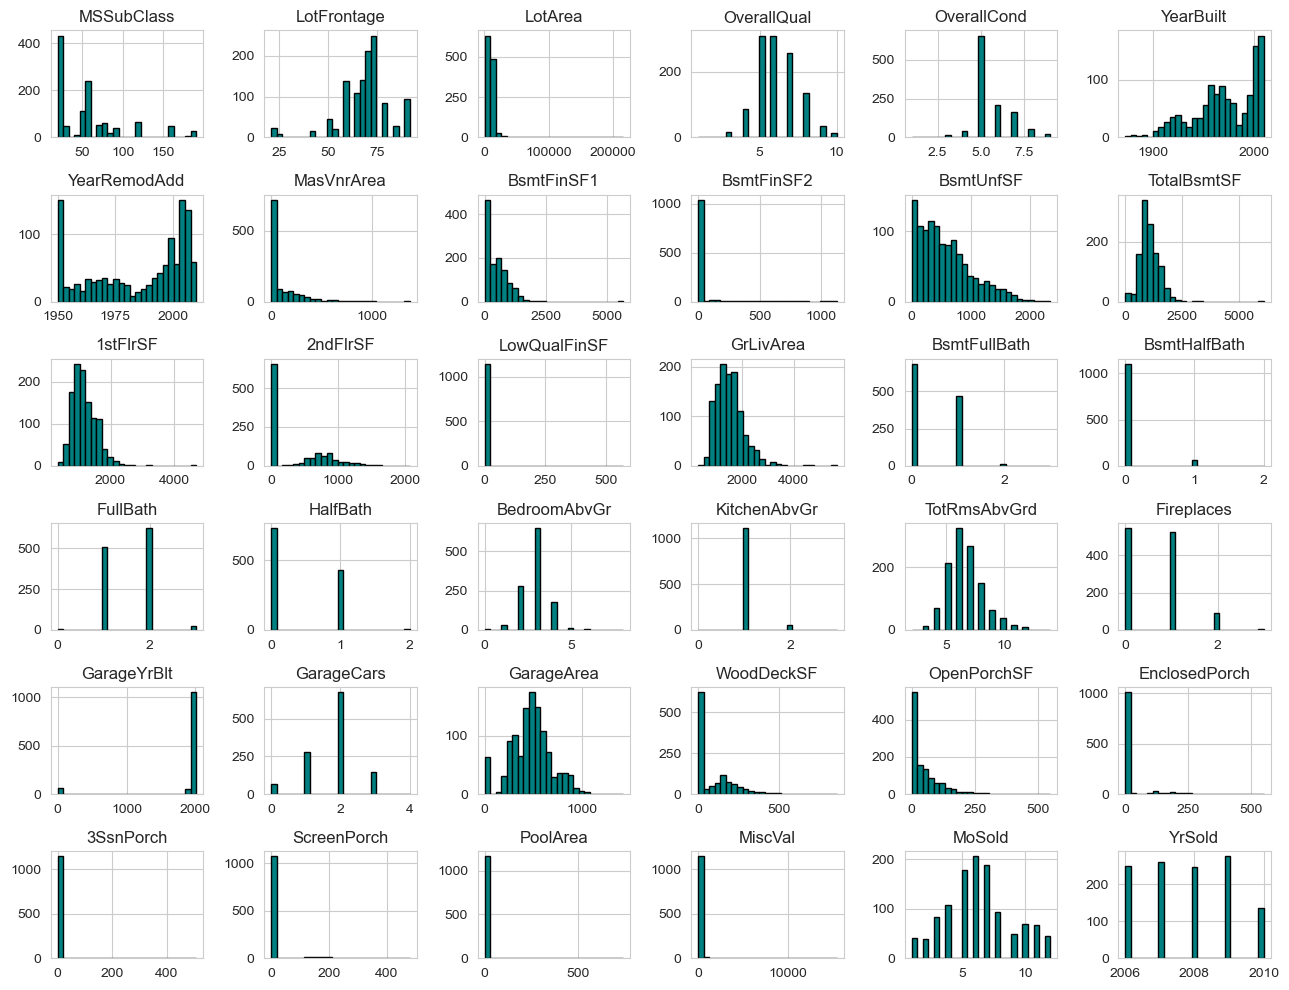

In [11]:
# Numeric feature histograms
numeric_columns = train_data.drop(['SalePrice', 'LogSalePrice'], axis = 1).select_dtypes(include = 'number').columns

train_data[numeric_columns].hist(
    figsize = (13, 10), bins = 25, edgecolor = 'black',
    sharex = False, sharey = False
)
plt.tight_layout()
plt.show()

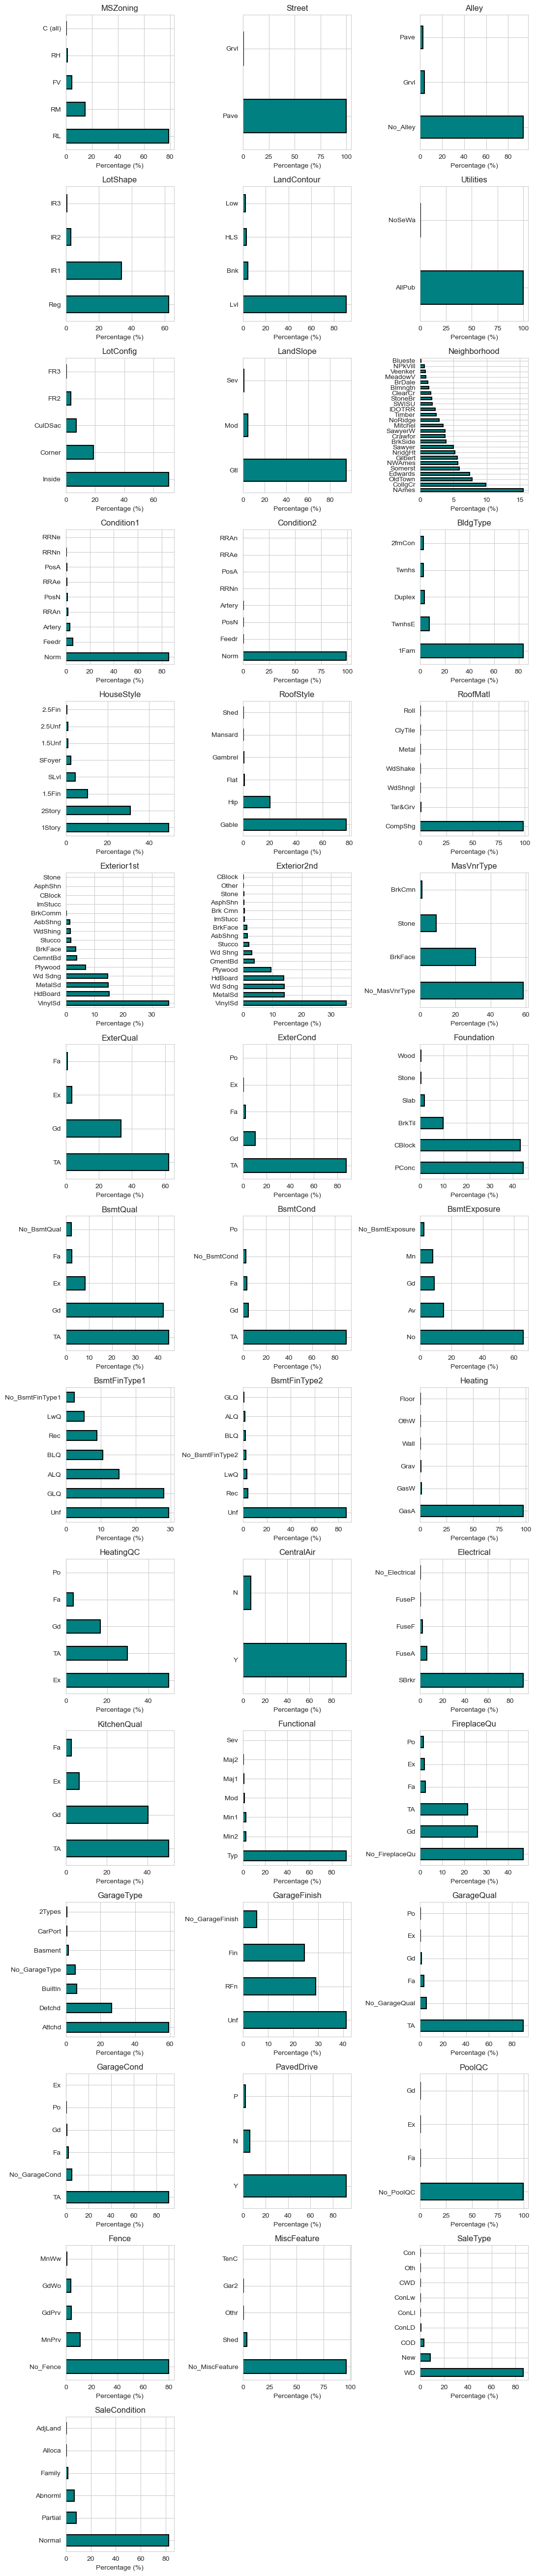

In [12]:
# Categorical feature barplots
categorical_columns = train_data.select_dtypes(include = 'object').columns

n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (11, 3.5 * n_rows))
axes = axes.flatten() 

for i, col in enumerate(categorical_columns):
    counts = train_data[col].value_counts(normalize = True) * 100 
    counts.plot(kind = 'barh', ax = axes[i], edgecolor = 'black', linewidth = 1.5)
    axes[i].set_title(col)
    axes[i].set_xlabel('Percentage (%)')
    axes[i].set_ylabel('')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Feature Engineering
- Create domain-relevant features, e.g., total square footage, adjusted bathroom count, garage age, porch area, externally-sourced neighborhood median house prices, quality•size interactions, etc.
- Encode ordinal categorical variables.

In [39]:
# Helper function for feature engineering
def engineer_features(df, price_median, lot_median):
    df = df.copy()
    # Area, age, and utility features
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['TotalFinishedSF'] = df['GrLivArea'] + df['BsmtFinSF1'] + df['BsmtFinSF2']
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['Bathrooms'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df['RoomsPerArea'] = df['TotRmsAbvGrd'] / df['GrLivArea']
    
    # Amenities and outdoor features
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasDeck'] = (df['WoodDeckSF'] > 0).astype(int)
    df['PorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['LotRatio'] = df['GrLivArea'] / df['LotArea']
    
    # Location features (map from training to avoid leakage/NaNs)
    df['NeighborhoodPriceMedian'] = df['Neighborhood'].map(price_median)
    df['LotFrontage'] = df['Neighborhood'].map(lot_median)
    
    # Urban-rural mapping
    urban = ['OldTown', 'Edwards', 'BrkSide', 'SWISU', 'Blueste', 'IDOTRR', 'MeadowV']
    suburban = ['CollgCr', 'Crawfor', 'Gilbert', 'Sawyer', 'SawyerW', 'NAmes',
                'Mitchel', 'Timber', 'NPkVill', 'NWAmes']
    rural = ['StoneBr', 'NoRidge', 'NridgHt', 'ClearCr', 'Somerst',
             'Blmngtn', 'Northridge', 'NorthridgHt', 'Veenker']
    
    def urb_rur(val):
        if val in urban: return 'Urban'
        elif val in suburban: return 'Suburban'
        elif val in rural: return 'Rural'
        else: return 'Other'
            
    df['UrbanRural'] = df['Neighborhood'].map(urb_rur)
    
    # Interactions
    df['QualCond'] = df['OverallQual'] * df['OverallCond']
    df['QualSize'] = df['OverallQual'] * df['GrLivArea']
    df['GarageSizeCapacity'] = df['GarageCars'] * df['GarageArea']
    df['QualSF'] = df['OverallQual'] * df['TotalSF']
    df['GaragePerArea'] = df['GarageArea'] / df['GrLivArea']

    # Cardinal encoding
    qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    quality_cols = [
        'BsmtQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
        'PoolQC', 'ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC'
    ]
    
    for col in quality_cols:
        df[col] = df[col].apply(
            lambda x: 0 if isinstance(x, str) and x.startswith('No') else qual_map.get(x, 0)
        )

    # High-cardinality nominal variable encoding
    high_card_nom = ['Exterior1st', 'Exterior2nd', 'Neighborhood']
    for col in high_card_nom:
        freq = df[col].value_counts(normalize = True)
        df[col + '_freq'] = df[col].map(freq)
        df.drop(columns = col, inplace = True)

    return df

train_data = engineer_features(train_data, neighborhood_price_median, neighborhood_lot_median)

## Feature Transformation
Apply log transformation to skewed numeric features to improve model performance.

In [75]:
# Helper function for feature tranformation
def feature_transform(df):
    df = df.copy()
    exclude = ['SalePrice', 'LogSalePrice']
    numeric_cols = df.select_dtypes(include='number').columns.difference(exclude)

    for col in numeric_columns:
        if np.issubdtype(df[col].dtype, np.number):
            df[col] = np.log1p(df[col].clip(lower=0) + 0.01)
    
    return df

train_data = feature_transform(train_data)

# Transformed numeric feature histograms
exclude = ['SalePrice', 'LogSalePrice']
numeric_columns = train_data.select_dtypes(include='number').columns.difference(exclude)
axes = train_data[numeric_columns].hist(
    figsize = (13, 10), 
    bins = 25,
    edgecolor = 'black',
    sharex = False,
    sharey = False
)
for ax_row in axes:
    for ax in ax_row:
        ax.set_xticklabels([])
fig = axes[0][0].get_figure()
fig.set_size_inches(20, 15)
plt.show()

## Categorical Encoding
Encode nominal categorical variables into indicator variables.

In [41]:
def encode_categoricals(df):
    df = df.copy()
    one_hot_columns = df.select_dtypes(include = 'object').columns
    df = pd.get_dummies(df, columns = one_hot_columns, drop_first = True)

    return df

train_data = encode_categoricals(train_data)

In [42]:
print(train_data.select_dtypes(include = 'object').columns)

Index([], dtype='object')


## Prepare Training Features and Targets

In [43]:
X_train = train_data.drop(['SalePrice', 'LogSalePrice'], axis = 1)
y_train = train_data[['SalePrice', 'LogSalePrice']]

y_train.head(2)

,SalePrice,LogSalePrice
254,145000.0,11.884496
1066,178000.0,12.089544


## Prepare Test Features and Targets
- Performed preprocessing
- Prepare test teatures and targets
- Reindexed test features to align with training features to prevent mismatch.

In [44]:
test_data = test_data.drop('Id', axis = 1)
test_data = handle_missing(test_data)
test_data = target_transform(test_data)
test_data = engineer_features(test_data, neighborhood_price_median, neighborhood_lot_median)
test_data = feature_transform(test_data)
test_data = encode_categoricals(test_data)

In [45]:
# Extract test features/targets and align with training
X_test = test_data.drop(['SalePrice', 'LogSalePrice'], axis = 1)
y_test = test_data[['SalePrice', 'LogSalePrice']]

X_test = X_test.reindex(columns = X_train.columns, fill_value = 0)

## Preprocessor Definition
Build pipelines for numeric feature preprocessing: imputation and optional scaling.

In [46]:
def make_preprocessor(continuous_features, scale = True):
    if scale:
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                             ('scaler', StandardScaler())])
    else:
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median'))])

    return ColumnTransformer([('num', num_pipe, continuous_features)], remainder = 'passthrough')

In [47]:
# Preprocessor instance (no scaling)
continuous_features = X_train.select_dtypes(include = ['float64']).columns.tolist()
preprocessor = make_preprocessor(continuous_features, scale = False)

## Base Model Training and Evaluation
- Define base learners: **Ridge, Random Forest**, and **Gradient Boosting**.  
- Use cross-validation to evaluate their log-RMSE performance.
- Use test data to evaluate their log-RMSE performance.

**Evaluation Results**:
|Model              | CV RMSE    | Test RMSE |
|-------------------|------------|-----------|
|Ridge            🥈| 0.134726   | 0.134243  |
|RandomForest     🥉| 0.139180   | 0.144454  |
|GradientBoosting 🥇| 0.125139   | 0.134765  |

In [48]:
models = {
    'RidgeCV': RidgeCV(alphas = np.logspace(-3, 3, 20), cv = 5),
    'RandomForest': RandomForestRegressor(
        n_estimators = 500, 
        random_state = 42, 
        n_jobs = -1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators = 1000, 
        learning_rate = 0.05, 
        max_depth = 3, 
        random_state = 42
    )
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Cross validation
    cv_scores = cross_val_score(
        pipeline,
        X_train,
        y_train['LogSalePrice'],
        cv = 5,
        scoring = 'neg_root_mean_squared_error',
        n_jobs = -1
    )
    cv_rmse = -np.mean(cv_scores)

    # Fit and test
    pipeline.fit(X_train, y_train['LogSalePrice'])
    y_pred_log = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test['LogSalePrice'], y_pred_log))

    results.append((name, cv_rmse, test_rmse))

for name, cv_rmse, test_rmse in results:
    print(f'{name} --> CV RMSE (log): {cv_rmse:.6f} | Test RMSE (log): {test_rmse:.6f}')

RidgeCV --> CV RMSE (log): 0.134726 | Test RMSE (log): 0.134243
RandomForest --> CV RMSE (log): 0.139180 | Test RMSE (log): 0.144454
GradientBoosting --> CV RMSE (log): 0.125139 | Test RMSE (log): 0.134765


## Additional Evaluations
- **Residual Analysis**: Plot residuals vs actual sale price for each base model to check bias and variance.
- **Feature Importance**: Show top predictive features for **Ridge** (coefficients), **Random Forest**, and **Gradient Boosting**.

**Results**:
- **Residual Analysis**
  - Despite log transformation of target, residual plots reveal mild heteroscedasticity at higher prices
  - Gradient Boosting exhibits the most uniform dispersion, outperforming Ridge and Random Forest in predictive stability.
<br><br>
- **Feature Importance**
| Model            | Top Features                                   |
|------------------|-------------------------------------------------------|
| RidgeCV          | NeighborhoodPriceMedian🥇<br>TotalFinishedSF🥈<br>TotalSF🥉 |
| RandomForest     | QualSF🥇 <br>NeighborhoodPriceMedian🥈 <br>QualSize🥉 |
| GradientBoosting | QualSF🥇 <br>NeighborhoodPriceMedian🥈 <br>QualSize🥉 |

Results suggest that quality ratings, property size, and neighborhood median price are the strongest drivers of house prices.

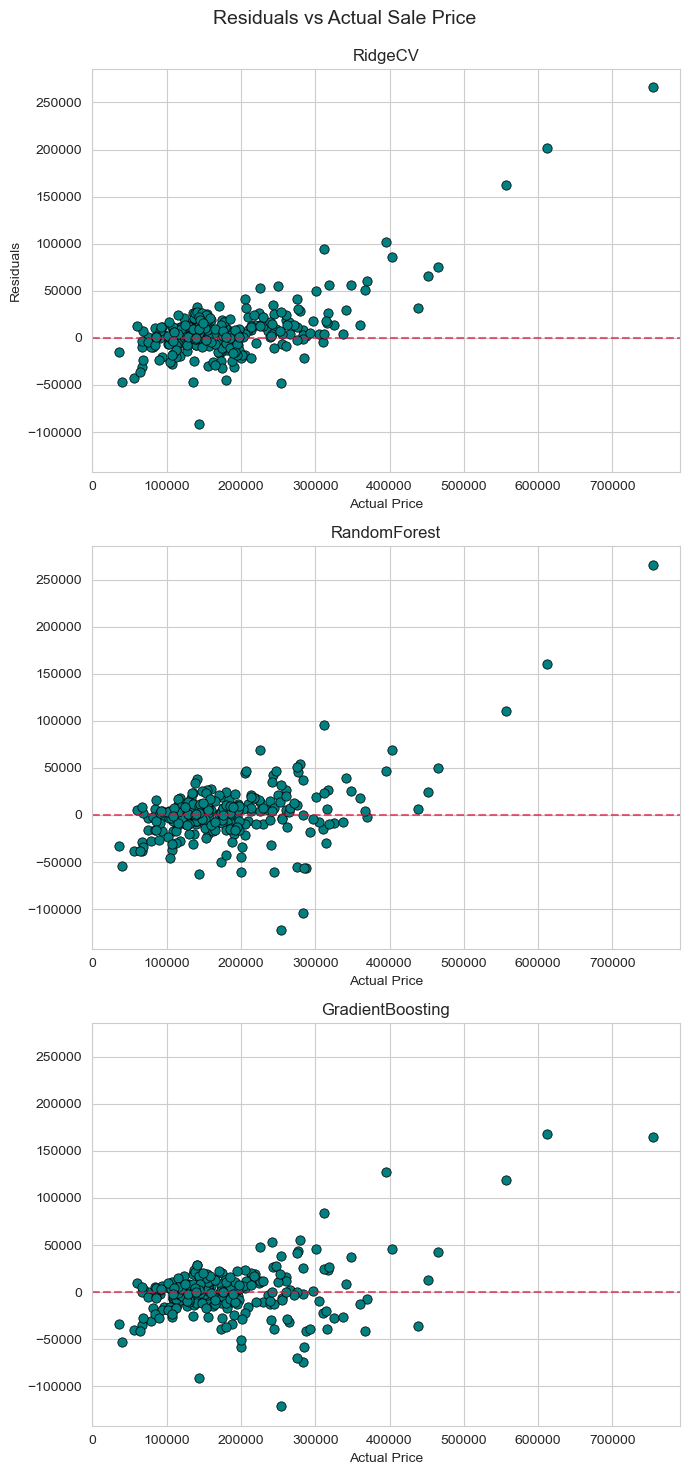

In [49]:
fig, axes = plt.subplots(len(models), 1, figsize = (7, 5 * len(models)), sharey = True)

for ax, (name, model) in zip(axes, models.items()):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train['LogSalePrice'])

    y_pred_log = pipeline.predict(X_test)
    y_pred_dollars = np.expm1(y_pred_log)
    y_actual_dollars = np.expm1(y_test['LogSalePrice'])
    residuals = y_actual_dollars - y_pred_dollars

    sns.scatterplot(x = y_actual_dollars, y = residuals, s = 45, edgecolor = 'black', ax = ax)
    ax.axhline(0, color = '#DC143CAA', linestyle = '--', linewidth = 1.5)
    ax.set_title(f'{name}')
    ax.set_xlabel('Actual Price')
    if ax == axes[0]:
        ax.set_ylabel('Residuals')
    else:
        ax.set_ylabel('')

plt.suptitle('Residuals vs Actual Sale Price\n', fontsize = 14)
plt.tight_layout()
plt.show()

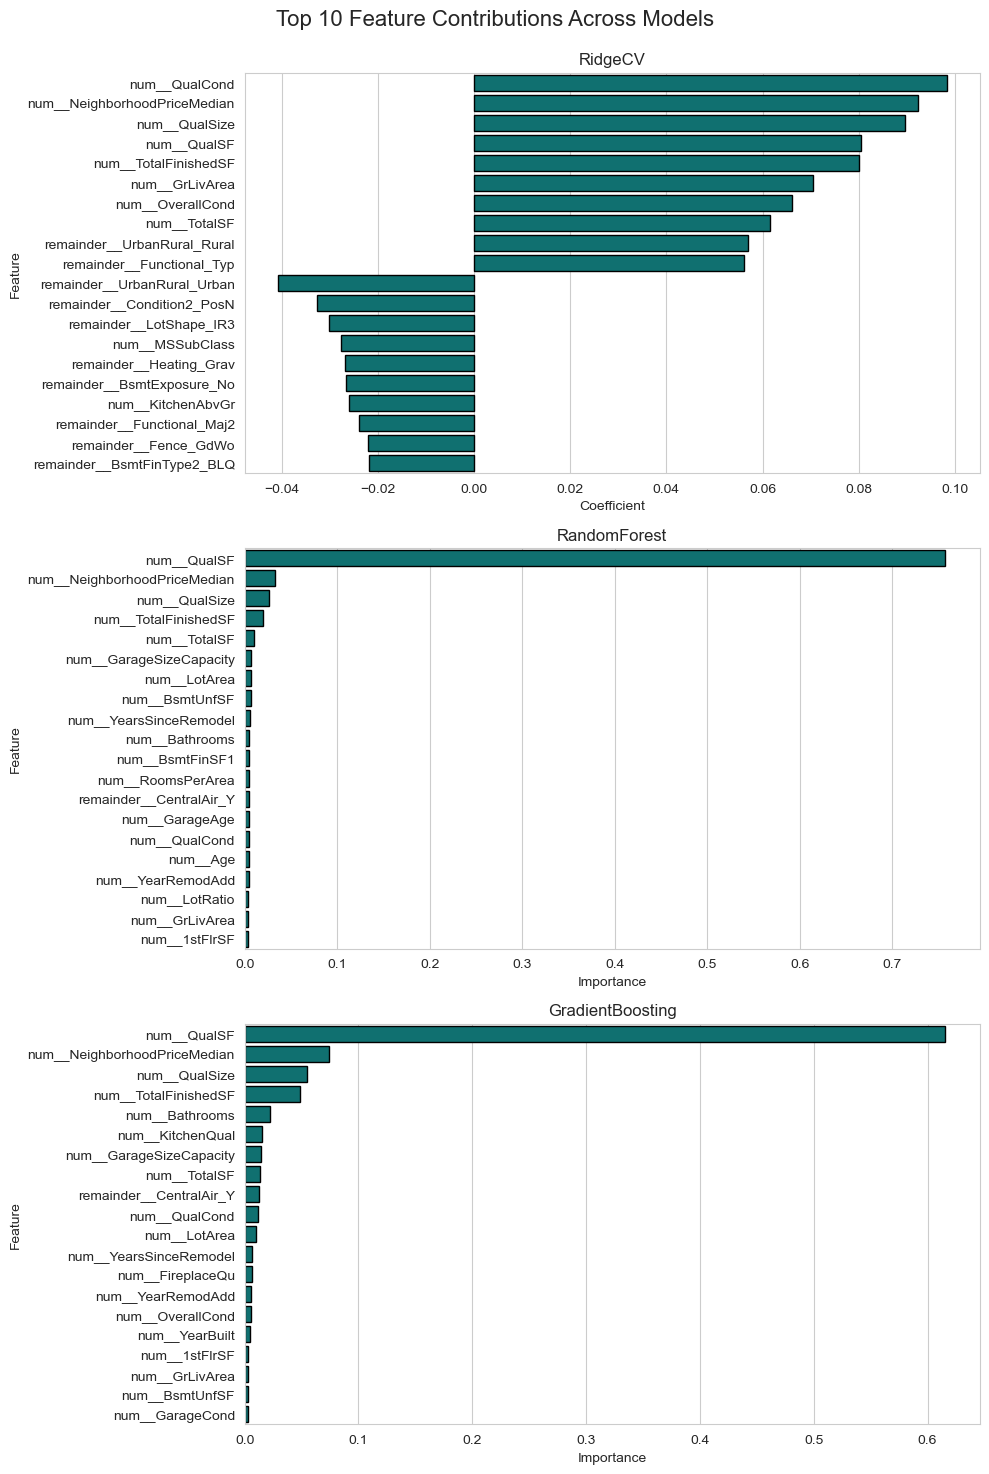

In [50]:
pipelines = {
    name: Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ]).fit(X_train, y_train['LogSalePrice'])
    for name, model in models.items()
}

feature_names = getattr(preprocessor, 'get_feature_names_out', lambda: [f'feature_{i}' for i in range(X_train.shape[1])])()

# Helper to extract top features
def extract_features(model, feature_names, top = 20, ridge = False):
    if ridge:
        values = model.coef_
        df = pd.DataFrame({'Feature': feature_names, 'Value': values})
        return pd.concat([df.nlargest(top//2, 'Value'), df.nsmallest(top//2, 'Value')])
    else:
        values = getattr(model, 'feature_importances_', None)
        return pd.DataFrame({'Feature': feature_names, 'Value': values}).nlargest(top, 'Value')

plot_data = {
    'RidgeCV': extract_features(pipelines['RidgeCV'].named_steps['regressor'], feature_names, top = 20, ridge = True),
    'RandomForest': extract_features(pipelines['RandomForest'].named_steps['regressor'], feature_names),
    'GradientBoosting': extract_features(pipelines['GradientBoosting'].named_steps['regressor'], feature_names)
}

fig, axes = plt.subplots(len(plot_data), 1, figsize = (10, 5 * len(plot_data)))

for ax, (name, df) in zip(axes, plot_data.items()):
    sns.barplot(data = df, x = 'Value', y = 'Feature', ax = ax, edgecolor = 'black')
    ax.set_title(name)
    ax.set_xlabel('Coefficient' if name == 'RidgeCV' else 'Importance')
    ax.set_ylabel('Feature')

plt.suptitle('Top 10 Feature Contributions Across Models\n', fontsize = 16)
plt.tight_layout()
plt.show()

## Stacking Regressor
- **Base models**: Ridge, Random Forest, Gradient Boosting
- **Meta-learner**: Linear Regression
- **Evaluation metric**: Root Mean Squared Error (RMSE) on log-transformed target

**Results**:
  - Cross-validation RMSE (log) ≈ 0.123196
  - Test RMSE (log) ≈ 0.128989 🏆

**Interpretation**:

- The stacked model shows strong generalization.
- The cross validated error and the independent test error are very close, suggesting minimal overfitting and that the model can perform competitively on unseen data.

In [51]:
# Base models
base_models = [
    ('gb', GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.05, max_depth = 3, random_state = 42)),
    ('rf', RandomForestRegressor(n_estimators = 500, random_state = 42)),
    ('ridge', RidgeCV(alphas = np.logspace(-3, 3, 20), cv = 5))
]

pipelines = [(name, Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])) for name, model in base_models]

# Stacked model with linear meta-model
stacked_model = StackingRegressor(
    estimators = pipelines,
    final_estimator = LinearRegression(),
    cv = 5,
    passthrough = False,
    n_jobs = -1
)

# CV with RMSE
cv_scores = cross_val_score(
    stacked_model,
    X_train,
    y_train['LogSalePrice'],
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)
cv_rmse = -np.mean(cv_scores)

# Fit and test
stacked_model.fit(X_train, y_train['LogSalePrice'])
y_pred_log = stacked_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test['LogSalePrice'], y_pred_log))

print(f'Stacked Model --> CV RMSE (log): {cv_rmse:.6f} | Test RMSE (log): {test_rmse:.6f}')

Stacked Model --> CV RMSE (log): 0.123196 | Test RMSE (log): 0.128989


## Submission

In [81]:
# Read, preprocess, and predict on competition test set
comp_data = pd.read_csv('test.csv')

ids = comp_data['Id']

X_comp = comp_data.drop('Id', axis = 1)
X_comp = handle_missing(X_comp)
X_comp = engineer_features(X_comp, neighborhood_price_median, neighborhood_lot_median)
X_comp = feature_transform(X_comp)
X_comp = encode_categoricals(X_comp)
X_comp = X_comp.reindex(columns = X_train.columns, fill_value = 0)

# Predict with stacked model
preds = stacked_model.predict(X_comp)

# Invert log transformation
preds = np.expm1(preds)

# Build submission DataFrame
output = pd.DataFrame({
    'Id': ids,
    'SalePrice': preds
})

output.head(2)

,Id,SalePrice
0,1461,118987.186917
1,1462,158081.583672


In [80]:
# Submit
# output.to_csv('/kaggle/working/submission.csv', index = False)

## Versions

In [18]:
show_versions()
print(f'seaborn: {sns.__version__}')


System:
    python: 3.11.0 (heads/3.11-dirty:785b3676ef, Jan 18 2024, 18:53:12) [Clang 15.0.0 (clang-1500.1.0.2.5)]
executable: /private/var/containers/Bundle/Application/886DA911-9AD2-4750-B9D3-D777124926A3/Carnets-sci.app/Library/bin/pythonA
   machine: macOS-18.6-iPhone15,3-arm-64bit

Python dependencies:
      sklearn: 1.2.2
          pip: 23.3.2
   setuptools: 69.0.3
        numpy: 1.25.2+2.g530bd4c06
        scipy: 1.11.2
       Cython: 3.0.0
       pandas: 2.0.3
   matplotlib: 3.9.0.dev16+g5446a454e4
       joblib: 1.3.2
threadpoolctl: 3.2.0

Built with OpenMP: False
seaborn: 0.13.1
